In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
print(sys.executable)

/usr/bin/python3


In [5]:
!jupyter kernelspec list

Available kernels:
  ir         /usr/local/share/jupyter/kernels/ir
  python3    /usr/local/share/jupyter/kernels/python3


### Inports

In [6]:
import os
import glob
import math
import json
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage import io
from skimage import color
from tensorflow import keras
from collections import defaultdict
from skimage.transform import resize
from zipfile import ZipFile, BadZipFile
from tensorflow.keras.callbacks import ModelCheckpoint

### GPU support

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        print('enable gpu')
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

enable gpu
1 Physical GPUs, 1 Logical GPUs


### Global variables

In [8]:
ROOT_FILE_PATH = "/content/drive/MyDrive/Google Drive - Code/nthu/ML/2023-Machine-Learning-Dataset"
AREAS = ["prf-visualrois", "floc-bodies", "floc-faces", "floc-places", "floc-words", "streams", "all-vertices"]
MASK_KEYS = ["lh.fsaverage_space", "rh.fsaverage_space", "lh.space", "rh.space", "mapping"]
SUBJ_LIST = ["subj01", "subj02", "subj04", "subj05", "subj06", "subj07", "subj08"] # "subj03", 
VAL_ANNOTATIONS = "coco_ann2017/annotations/instances_val2017.json"
TRAIN_ANNOTATIONS = "coco_ann2017/annotations/instances_train2017.json"

In [9]:
file_seperator = '/'

In [10]:
def ReadNpyFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + f"{file_seperator}*.npy"):
    filename = os.path.splitext(path)[0].split(f"{file_seperator}")[-1]
    return_dic[filename] = np.load(path, allow_pickle = True)
  return return_dic

def ReadFmriFile(dir_path):
  return_dic = {}
  for path in glob.glob(dir_path + f"{file_seperator}*.npy"):
    filename = os.path.splitext(path)[0].split(f"{file_seperator}")[-1]
    return_dic[filename[0]] = np.load(path, allow_pickle = True)
  return return_dic

def ReadMaskFile(dir_path):
  return_dic = {area: {} for area in AREAS}
  for path in glob.glob(dir_path + f"{file_seperator}*.npy"):
    filename = os.path.splitext(path)[0].split(f"{file_seperator}")[-1]
    for area in AREAS:
      if area in filename:
        filename = "".join(i.strip("_") for i in filename.split(area))
        return_dic[area][filename] = np.load(path, allow_pickle = True) if filename[0] != "m" else np.load(path, allow_pickle = True).item()
        break
  return return_dic

def FetchPngFile(dir_path, index, mode = "rgb"):
  # img = iio.v3.imread()
  img = io.imread(os.path.join(dir_path, f'{index}.png'))
  if mode == "rgb":
    return img
  if mode == "hsv":
    return color.rgb2hsv(img)
    # return matplotlib.colors.rgb_to_hsv(img)
  if mode == "gray":
    return color.rgb2gray(img)
    # return np.dot(img, [0.299, 0.587, 0.114])

In [11]:
def ApplyRoiMask(roi, fmri, mask):
    hemisphere = ["l", "r"]
    # Define the ROI class based on the selected ROI
    if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
        roi_class = 'prf-visualrois'
    elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
        roi_class = 'floc-bodies'
    elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
        roi_class = 'floc-faces'
    elif roi in ["OPA", "PPA", "RSC"]:
        roi_class = 'floc-places'
    elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
        roi_class = 'floc-words'
    elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
        roi_class = 'streams'
    result = {}
    for items in hemisphere:
        _hfmri = fmri[items]
        roi_map = mask[roi_class]['mapping']
        challenge_roi_class = mask[roi_class][items+'h.space']
        roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
        challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
        result[items] = np.zeros(_hfmri.shape)
        result[items][:, np.where(challenge_roi)[0]] = _hfmri[:, np.where(challenge_roi)[0]]
    return result

In [12]:
def train_val_split(x, y, ratio, random_state=42):

  r = np.random.RandomState(random_state)

  idx = r.permutation(x.index)
  x_per = x.reindex(idx)
  y_per = y.reindex(idx)

  train_size = int(x.shape[0] * ratio)

  x_train = x_per[0:train_size]
  y_train = y_per[0:train_size]

  x_val = x_per[train_size:]
  y_val = y_per[train_size:]

  print('Training_dimension: ' + str(x_train.shape) + ' | ' + str(y_train.shape))
  print('Validation_dimension: ' + str(x_val.shape) + ' | ' + str(y_val.shape))

  return x_train, x_val, y_train, y_val

In [14]:
def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)

In [15]:
class COCOParser:

    def __init__(self, anns_file):

        with open(anns_file, 'r') as f:
            coco = json.load(f)

        self.annIm_dict = defaultdict(list)
        self.cat_dict = {}
        self.annId_dict = {}
        self.im_dict = {}

        for ann in coco['annotations']:
            self.annIm_dict[ann['image_id']].append(ann)
            self.annId_dict[ann['id']]=ann

        for img in coco['images']:
            self.im_dict[img['id']] = img

        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat

    def get_imgIds(self):
        return list(self.im_dict.keys())

    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]

    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]

    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]

In [18]:
def get_bounding_boxes(paser, id_list, area_threshold=0):
    annIds = paser.get_annIds(id_list)
    anns = paser.load_anns(annIds)
    ret_dict = {}
    for id in id_list:
        ret_dict[id] = []
        for ann in anns:
            bbox = ann["bbox"]
            x, y, w, h = [int(b) for b in bbox]
            class_id = ann["category_id"]
            class_name = paser.load_cats(class_id)[0]["name"]
            if w * h <= area_threshold:
                # (bounding box as 4-tuple, classname)
                ret_dict[id].append(((x, y, w, h), class_name))
    return ret_dict

In [19]:
class ReadObject:

  #fmri = None           # dict(string -> ndarray, float32)
  #masks = None          # dict(string "AREA" -> (dict(int -> string), string "HEMISPHERE, " -> ndarray))

  #image_labels = None   # dataframe
  #label_names = None    # list

  subject = None        # string

  def __init__(self, subject):
    self.subject = subject

  # Mode = "train" | "test"
  def load(self, mode="train", load_images=True, image_mode="gray", image_count=-1):

    loaded_fmri = None
    loaded_images = None

    image_infos = pd.read_csv(os.path.join(ROOT_FILE_PATH, "image_infos", f"{self.subject}_infos_train.csv"))

    cocoIds = image_infos.get('cocoId')

    cocoSplit = image_infos.get('cocoSplit')

    image_labels = image_infos.drop(image_infos.columns[[0, 1]], axis=1)

    label_names = image_labels.columns

    image_labels = image_labels.to_numpy(dtype=int)

    masks = ReadMaskFile(os.path.join(ROOT_FILE_PATH, self.subject , "roi_masks"))

    if load_images:
      image_count = image_labels.shape[0] if image_count is -1 else image_count
      print(f'Images: {image_count} | Labels: {image_labels.shape[1]} | Masks: {len(masks.keys())}')
    else:
      print(f'Labels: {image_labels.shape[1]} | Masks: {len(masks.keys())}')

    if mode == "train":
      loaded_fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "training_split", "training_fmri"))
      if load_images:

        print(f'Load {image_count} training images..')
        loaded_images = np.stack([
          FetchPngFile(os.path.join(ROOT_FILE_PATH, self.subject, "training_split", "training_images"), idx, mode = image_mode) for idx in range(image_count)
        ])
    elif mode == "test":
      loaded_fmri = ReadFmriFile(os.path.join(ROOT_FILE_PATH, self.subject, "test_split", "test_fmri"))

    return cocoIds, cocoSplit, label_names, image_labels, masks, loaded_fmri, loaded_images

  def split_data(self, image_labels, fmri, images, split_ratio=None, permutate=True, count=None, random_state=42):

    idx_train, idx_val = None, None
    images_train, images_val = None, None
    labels_val, fmri_l_val, fmri_r_val = None, None, None

    if split_ratio is None:
      split_ratio = 1

    random_state = np.random.RandomState(random_state)

    if count is not None and count > 0:
      fmri_l_train = fmri['l'][:count]
      fmri_r_train = fmri['r'][:count]
      labels_train = np.array(image_labels[:count], dtype='int32')
      if images is not None:
        images_train = images[:count]
    else:
      fmri_l_train = fmri['l']
      fmri_r_train = fmri['r']
      labels_train = np.array(image_labels, dtype='int32')
      if images is not None:
          images_train = images

    if permutate:

        idx_train = random_state.permutation(labels_train.shape[0])

        fmri_l_train = fmri_l_train[idx_train]
        fmri_r_train = fmri_r_train[idx_train]
        labels_train = labels_train[idx_train]
        if images_train is not None:
          images_train = images_train[idx_train]

    if split_ratio < 1.0:

      train_size = int(labels_train.shape[0] * split_ratio)

      idx_val = idx_train[train_size:]
      fmri_l_val = fmri_l_train[train_size:]
      fmri_r_val = fmri_r_train[train_size:]
      labels_val = labels_train[train_size:]
      if images_train is not None:
        images_val = images_train[train_size:]

      idx_train = idx_train[0:train_size]
      fmri_l_train = fmri_l_train[0:train_size]
      fmri_r_train = fmri_r_train[0:train_size]
      labels_train = labels_train[0:train_size]
      if images_train is not None:
        images_train = images_train[0:train_size]

    return (labels_train, labels_val), (fmri_l_train, fmri_l_val), (fmri_r_train, fmri_r_val), (images_train, images_val), (idx_train, idx_val)

<>:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-19-a11f733b3419>:35: SyntaxWarning: "is" with a literal. Did you mean "=="?
  image_count = image_labels.shape[0] if image_count is -1 else image_count


In [21]:
def min_max_normalize(data, min=0, max=1, dtype='float32'):

  # Define the original range
  old_min = np.min(data)
  old_max = np.max(data)

  # Map the values from the original range to the new range
  data = (np.array(data, dtype=dtype) - old_min) * (max - min) / (old_max - old_min) + min

  return data

In [22]:
%matplotlib inline
def showSingleImage(subject, index, image_mode='gray'):
  image = FetchPngFile(os.path.join(ROOT_FILE_PATH, subject, "training_split", "training_images"), index, mode=image_mode)
  plt.imshow(image, cmap='gray')
  plt.show()

In [ ]:
%matplotlib inline
def visualise_data(label_names, labels, image, fmri_l, fmri_r, index=0):
  if label_names is not None and labels is not None:
    labels = np.array(label_names)[np.where(labels != 0)]
    print('labels', labels)
  if image is not None:
    print('image', image.shape)
    plt.imshow(image, cmap='gray')
    plt.show()
  if fmri_l is not None:
    print('fmri_l in 2D:', fmri_l[:,index].shape)
    plt.imshow(fmri_l[:,index].reshape(145, 145, 1), cmap='gray')
    plt.show()
  if fmri_r is not None:
    print('fmri_r in 2D:', fmri_r[:,index].shape)
    plt.imshow(fmri_r[:,index].reshape(145, 145, 1), cmap='gray')
    plt.show()

### Load subject train / val data

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

In [ ]:
extract_ann_path="./coco_ann2017"
extract_zip_file(extract_ann_path)

In [ ]:
val_coco_parser = COCOParser(VAL_ANNOTATIONS)
train_coco_parser = COCOParser(TRAIN_ANNOTATIONS)

In [21]:
# del global_labels_name, global_labels_train, global_labels_val,global_fmri_l_train, global_fmri_l_val, global_fmri_r_train, global_fmri_r_val, global_images_train, global_images_val, global_idx_train, global_idx_val

In [23]:
global_labels_name, global_labels_train, global_labels_val, global_fmri_l_train, global_fmri_l_val, global_fmri_r_train, global_fmri_r_val = None, None, None, None, None, None, None
global_images_train, global_images_val, global_idx_train, global_idx_val, global_train_count, global_val_count = None, None, None, None, None, None
global_idx_train, global_idx_val = None, None

load_mode= 'train'

# 1 - 8
subject_count = 2

# -1 for all or 0 for none or > 2 for images
image_count = 0
# gray, rgb
image_mode = "gray"
load_images = image_count > 0 and load_mode == 'train'

# Resize fmri 145 x 145
fit_fmri_dimension = True
fit_fmri_target_size = 21025

# Remove labels of object which are smaller than the threshold
area_threshold = 50*50
remove_labels = area_threshold > 0

# Masks ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]

mask_list = None

for sub in SUBJ_LIST[:subject_count]:

  print(sub)

  sub_obj = ReadObject(sub)

  cocoIds, cocoSplit, label_names, image_labels, masks, fmri, images = sub_obj.load(
      mode=load_mode, image_mode=image_mode, load_images=load_images, image_count=image_count)

  global_labels_name = label_names if global_labels_name is None else global_labels_name

  ## Remove labels

  if remove_labels:

    removed_count = 0

    label_names_list = label_names.tolist()

    assert cocoIds.shape[0] == cocoSplit.shape[0] == image_labels.shape[0], 'Dimension miss match'

    for index in range(cocoIds.shape[0]):

      id = cocoIds[index]
      split = cocoSplit[index]

      assert split == 'val2017' or split == 'train2017', 'Split not found'

      # print(id, split)

      parser = None

      if split == 'val2017':
        parser = val_coco_parser
      if split == 'train2017':
        parser = train_coco_parser

      obj_bounding_list = list(get_bounding_boxes(parser, [id], area_threshold=area_threshold).values())[0]
      indices_to_set_one = []

      for _, lable in obj_bounding_list:

        #print(lable, label_names_list.index(lable))

        indices_to_set_one.append(label_names_list.index(lable))

      indices_to_set_one = list(set(indices_to_set_one))

      #print(indices_to_set_one)

      before = np.sum(image_labels[index])

      image_labels[index][indices_to_set_one] = 0

      after = np.sum(image_labels[index])

      removed_count += abs(after - before)

    print('Removed', removed_count, 'lables smaller than threshold')

  ## Load masks

  if mask_list is not None:
    masked_fmri = {}
    print('Apply masks:', mask_list)
    for mask in mask_list:

        init = len(masked_fmri) == 0
        _masked_fmri = ApplyRoiMask(mask, fmri, masks)

        if init:
            masked_fmri['l'] = [_masked_fmri['l']]
            masked_fmri['r'] = [_masked_fmri['r']]
        else:
            masked_fmri['l'].append(_masked_fmri['l'])
            masked_fmri['r'].append(_masked_fmri['r'])

    if len(masked_fmri['l']) > 1:
        masked_fmri['l'] = np.stack(masked_fmri['l'], axis=-1)
    else:
        masked_fmri['l'] = masked_fmri['l'][0]
    if len(masked_fmri['r']) > 1:
        masked_fmri['r'] = np.stack(masked_fmri['r'], axis=-1)
    else:
        masked_fmri['r'] = masked_fmri['r'][0]

    fmri = masked_fmri
  else:
    fmri['l'] = fmri['l'].reshape(fmri['l'].shape[0], fmri['l'].shape[1], 1)
    fmri['r'] = fmri['r'].reshape(fmri['r'].shape[0], fmri['r'].shape[1], 1)

  ## Split data

  count = None if images is None else images.shape[0]
  split_ratio = 0.99 if load_mode == 'train' else 1

  ((labels_train, labels_val), (fmri_l_train, fmri_l_val), (fmri_r_train, fmri_r_val), (images_train, images_val), (idx_train, idx_val)) = (
    sub_obj.split_data(image_labels, fmri, images, split_ratio=split_ratio, count=count, permutate= load_mode=='train'))

  global_train_count = labels_train.shape[0] if global_train_count is None else global_train_count
  global_val_count = labels_val.shape[0] if global_val_count is None else global_val_count

  global_idx_train = idx_train if global_idx_train is None else np.concatenate((global_idx_train, idx_train), dtype='int32')
  if idx_val is not None:
    global_idx_val = idx_val if global_idx_val is None else np.concatenate((global_idx_val, idx_val), dtype='int32')

  ## Extend fmri arrays

  print(f"labels_train  shape: {labels_train.shape}")
  global_labels_train = labels_train if global_labels_train is None else np.vstack((global_labels_train, labels_train))

  if labels_val is not None:
    print(f"labels_val  shape: {labels_val.shape}")
    global_labels_val = labels_val if global_labels_val is None else np.vstack((global_labels_val, labels_val))

  if fit_fmri_dimension:
    additional_rows = np.zeros(shape=(fmri_l_train.shape[0], fit_fmri_target_size - fmri_l_train.shape[1], fmri_l_train.shape[2]))
    fmri_l_train = np.concatenate((fmri_l_train, additional_rows), axis=1)
  fmri_l_train = min_max_normalize(fmri_l_train) # fmri_l_train / np.max(fmri_l_train)
  print(f"fmri_l_train  shape: {fmri_l_train.shape} | min: {np.min(fmri_l_train)} max: {np.max(fmri_l_train)}")
  global_fmri_l_train = fmri_l_train if global_fmri_l_train is None else np.vstack((global_fmri_l_train, fmri_l_train))

  if fmri_l_val is not None:
    if fit_fmri_dimension:
      additional_rows = np.zeros(shape=(fmri_l_val.shape[0], fit_fmri_target_size - fmri_l_val.shape[1], fmri_l_train.shape[2]))
      fmri_l_val = np.concatenate((fmri_l_val, additional_rows), axis=1)
    fmri_l_val = min_max_normalize(fmri_l_val) # fmri_l_val / np.max(fmri_l_val)
    print(f"fmri_l_val  shape: {fmri_l_val.shape} | min: {np.min(fmri_l_val)} max: {np.max(fmri_l_val)}")
    global_fmri_l_val = fmri_l_val if global_fmri_l_val is None else np.vstack((global_fmri_l_val, fmri_l_val))

  if fit_fmri_dimension:
    additional_rows = np.zeros(shape=(fmri_r_train.shape[0], fit_fmri_target_size - fmri_r_train.shape[1], fmri_l_train.shape[2]))
    fmri_r_train = np.concatenate((fmri_r_train, additional_rows), axis=1)
  fmri_r_train = min_max_normalize(fmri_r_train) # fmri_r_train / np.max(fmri_r_train)
  print(f"fmri_r_train  shape: {fmri_r_train.shape} | min: {np.min(fmri_r_train)} max: {np.max(fmri_r_train)}")
  global_fmri_r_train = fmri_r_train if global_fmri_r_train is None else np.vstack((global_fmri_r_train, fmri_r_train))

  if fmri_r_val is not None:
    if fit_fmri_dimension:
      additional_rows = np.zeros(shape=(fmri_r_val.shape[0], fit_fmri_target_size - fmri_r_val.shape[1], fmri_l_train.shape[2]))
      fmri_r_val = np.concatenate((fmri_r_val, additional_rows), axis=1)
    fmri_r_val = min_max_normalize(fmri_r_val) # fmri_r_val / np.max(fmri_r_val)
    print(f"fmri_r_val  shape: {fmri_r_val.shape} | min: {np.min(fmri_r_val)} max: {np.max(fmri_r_val)}")
    global_fmri_r_val = fmri_r_val if global_fmri_r_val is None else np.vstack((global_fmri_r_val, fmri_r_val))

  ## Norm images

  if load_images:

    if image_mode == 'rgb':
      images_train = images_train / 255.
    elif image_mode == 'gray':
      images_train = images_train.reshape((-1, images_train.shape[1], images_train.shape[2], 1))

    print(f"images_train  shape: {images_train.shape} | min: {np.min(images_train)} max: {np.max(images_train)}")
    global_images_train = images_train if global_images_train is None else np.vstack((global_images_train, images_train))

    if image_mode == 'rgb':
      images_val = images_val / 255.
    elif image_mode == 'gray':
      images_val = images_val.reshape((-1, images_val.shape[1], images_val.shape[2], 1))

    print(f"images_val  shape: {images_val.shape} | min: {np.min(images_val)} max: {np.max(images_val)}")
    global_images_val = images_val if global_images_val is None else np.vstack((global_images_val, images_val))

  # Free memory

  del cocoIds, cocoSplit, label_names, image_labels, masks, fmri, images

  del labels_train, labels_val, fmri_l_train, fmri_l_val, fmri_r_train, fmri_r_val

  if load_images:
    del images_train, images_val

  if fit_fmri_dimension:
    del additional_rows

  if remove_labels:
    del label_names_list

  print('')

subj01
Labels: 133 | Masks: 7
Removed 5720 lables
labels_train  shape: (4950, 133)
labels_val  shape: (50, 133)
fmri_l_train  shape: (4950, 21025, 1) | min: 0.0 max: 1.0
fmri_l_val  shape: (50, 21025, 1) | min: 0.0 max: 1.0
fmri_r_train  shape: (4950, 21025, 1) | min: 0.0 max: 1.0
fmri_r_val  shape: (50, 21025, 1) | min: 0.0 max: 1.0

subj02
Labels: 133 | Masks: 7
Removed 5547 lables
labels_train  shape: (4950, 133)
labels_val  shape: (50, 133)
fmri_l_train  shape: (4950, 21025, 1) | min: 0.0 max: 1.0
fmri_l_val  shape: (50, 21025, 1) | min: 0.0 max: 1.0
fmri_r_train  shape: (4950, 21025, 1) | min: 0.0 max: 1.0
fmri_r_val  shape: (50, 21025, 1) | min: 0.0 max: 1.0


In [24]:
print('Global train shapes:')
print(global_labels_train.shape, global_labels_train.dtype)
print(global_labels_val.shape, global_labels_val.dtype)
print(global_fmri_l_train.shape, global_fmri_l_train.dtype)
print(global_fmri_l_val.shape, global_fmri_l_val.dtype)
print(global_fmri_r_train.shape, global_fmri_r_train.dtype)
print(global_fmri_r_val.shape, global_fmri_r_val.dtype)
print(global_idx_train.shape, global_idx_train.dtype)
print(global_idx_val.shape, global_idx_val.dtype)

print(global_train_count)
print(global_val_count)

if load_images:
  print(global_images_train.shape, global_images_train.dtype)
  print(global_images_val.shape, global_images_val.dtype)

Global train shapes:
(9900, 133) int32
(100, 133) int32
(9900, 21025, 1) float32
(100, 21025, 1) float32
(9900, 21025, 1) float32
(100, 21025, 1) float32
(9900,) int32
(100,) int32
4950
50


In [25]:
count_categories = {}
for i in range(len(global_labels_name)):
    label_name = global_labels_name[i]
    label_column = global_labels_train[:, i]
    count = np.sum(label_column)
    count_categories[label_name] = count
print('Global train labels:', count_categories)

Global train labels:
{'person': 2960, 'bicycle': 132, 'car': 217, 'motorcycle': 190, 'airplane': 213, 'bus': 272, 'train': 324, 'truck': 272, 'boat': 133, 'traffic light': 46, 'fire hydrant': 112, 'stop sign': 103, 'parking meter': 28, 'bench': 291, 'bird': 146, 'cat': 343, 'dog': 330, 'horse': 202, 'sheep': 65, 'cow': 116, 'elephant': 186, 'bear': 100, 'zebra': 159, 'giraffe': 240, 'backpack': 163, 'umbrella': 192, 'handbag': 200, 'tie': 130, 'suitcase': 119, 'frisbee': 69, 'skis': 155, 'snowboard': 85, 'sports ball': 31, 'kite': 75, 'baseball bat': 73, 'baseball glove': 47, 'skateboard': 170, 'surfboard': 221, 'tennis racket': 206, 'bottle': 187, 'wine glass': 87, 'cup': 259, 'fork': 125, 'knife': 133, 'spoon': 125, 'bowl': 316, 'banana': 136, 'apple': 74, 'sandwich': 142, 'orange': 71, 'broccoli': 120, 'carrot': 50, 'hot dog': 65, 'pizza': 212, 'donut': 74, 'cake': 163, 'chair': 554, 'couch': 274, 'potted plant': 203, 'bed': 314, 'dining table': 786, 'toilet': 276, 'tv': 272, 'lapto

### Remove labels which appear often

In [27]:
count_threshold = 2000
labels_above_threshold = []
for index in range(len(count_categories)):
  label = list(count_categories.keys())[index]
  count = list(count_categories.values())[index]
  if count >= count_threshold:
    labels_above_threshold.append(label)

In [28]:
print(labels_above_threshold)

['person', 'tree-merged', 'sky-other-merged', 'grass-merged', 'wall-other-merged']


In [31]:
print(global_labels_name.tolist())

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'banner', 'blanket', 'bridge', 'cardboard', 'counter', 'curtain', 'door-stuff', 'floor-wood', 'flower', 'fruit', 'gravel', 'house', 'light

In [32]:
labels_indices_above_threshold = []
for label in labels_above_threshold:
  labels_indices_above_threshold.append(global_labels_name.tolist().index(label))
print(labels_indices_above_threshold)

[0, 116, 119, 125, 131]


In [37]:
global_labels_train[:,labels_indices_above_threshold] = 0
global_labels_val[:,labels_indices_above_threshold] = 0

In [40]:
count_categories = {}
for i in range(len(global_labels_name)):
    label_name = global_labels_name[i]
    label_column = global_labels_train[:, i]
    count = np.sum(label_column)
    count_categories[label_name] = count
print('Global train labels:',count_categories)

Global train labels: {'person': 0, 'bicycle': 132, 'car': 217, 'motorcycle': 189, 'airplane': 213, 'bus': 272, 'train': 324, 'truck': 272, 'boat': 133, 'traffic light': 46, 'fire hydrant': 112, 'stop sign': 103, 'parking meter': 28, 'bench': 290, 'bird': 146, 'cat': 343, 'dog': 330, 'horse': 202, 'sheep': 65, 'cow': 116, 'elephant': 186, 'bear': 99, 'zebra': 159, 'giraffe': 240, 'backpack': 163, 'umbrella': 192, 'handbag': 200, 'tie': 129, 'suitcase': 119, 'frisbee': 69, 'skis': 155, 'snowboard': 85, 'sports ball': 31, 'kite': 75, 'baseball bat': 73, 'baseball glove': 47, 'skateboard': 170, 'surfboard': 221, 'tennis racket': 206, 'bottle': 187, 'wine glass': 87, 'cup': 259, 'fork': 125, 'knife': 133, 'spoon': 125, 'bowl': 316, 'banana': 136, 'apple': 74, 'sandwich': 142, 'orange': 71, 'broccoli': 120, 'carrot': 50, 'hot dog': 65, 'pizza': 212, 'donut': 74, 'cake': 163, 'chair': 554, 'couch': 274, 'potted plant': 203, 'bed': 314, 'dining table': 786, 'toilet': 276, 'tv': 272, 'laptop': 

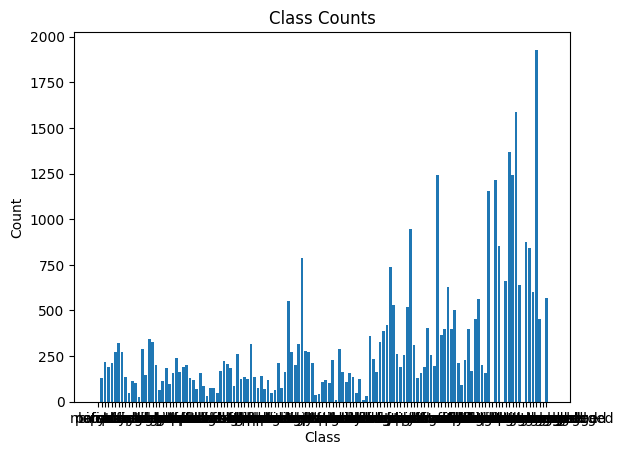

In [39]:
labels, counts = zip(*count_categories.items())
plt.bar(labels, counts)
plt.title('Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Test loaded training data

Label test of training data 6124:
labels ['person' 'bus' 'skateboard' 'road' 'tree-merged' 'sky-other-merged'
 'pavement-merged' 'building-other-merged' 'wall-other-merged']
fmri_l in 2D: (21025,)


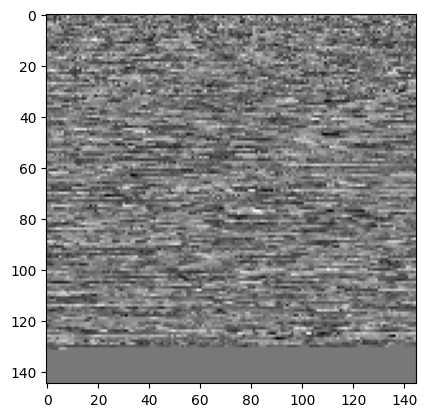

fmri_r in 2D: (21025,)


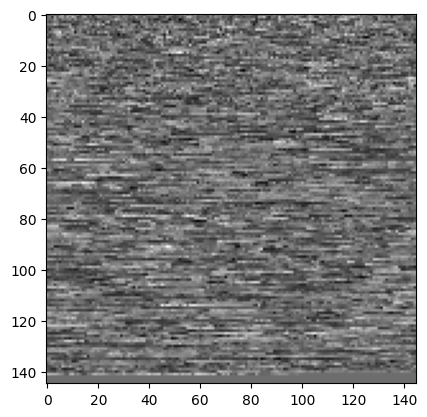

In [29]:
label_test_training_index = random.randint(0, global_labels_train.shape[0] - 1)
print(f'Label test of training data {label_test_training_index}:')
if load_images:
  visualise_data(global_labels_name, global_labels_train[label_test_training_index], global_images_train[label_test_training_index], global_fmri_l_train[label_test_training_index], global_fmri_r_train[label_test_training_index])
else:
    visualise_data(global_labels_name, global_labels_train[label_test_training_index], None, global_fmri_l_train[label_test_training_index], global_fmri_r_train[label_test_training_index])

### Image classification 1D

#### Combine fmri for 1D

In [31]:
# del global_X_train_1D, global_X_val_1D

In [32]:
print(f'Combine fmri data train (1D):')

global_X_train_1D = np.stack([global_fmri_l_train, global_fmri_r_train], axis=-1)
global_X_train_1D = global_X_train_1D.reshape(global_X_train_1D.shape[0], global_X_train_1D.shape[1], -1)
print(global_X_train_1D.shape)

print(f'\nCombine fmri data val (1D):')

global_X_val_1D = np.stack([global_fmri_l_val, global_fmri_r_val], axis=-1)
global_X_val_1D = global_X_val_1D.reshape(global_X_val_1D.shape[0], global_X_val_1D.shape[1], -1)
print(global_X_val_1D.shape)

Combine fmri data train (1D):
(19800, 21025, 2)

Combine fmri data val (1D):
(200, 21025, 2)


In [33]:
del global_fmri_l_train, global_fmri_r_train
del global_fmri_l_val, global_fmri_r_val

## Model for 1D

In [34]:
# del model1D

In [35]:
model1D = keras.models.Sequential()

model1D.add(keras.layers.Conv1D(filters=32, kernel_size=3, input_shape=(21025, global_X_train_1D.shape[2])))
model1D.add(keras.layers.BatchNormalization())
model1D.add(keras.layers.ReLU())
model1D.add(keras.layers.Conv1D(filters=32, kernel_size=3))
model1D.add(keras.layers.BatchNormalization())
model1D.add(keras.layers.ReLU())
model1D.add(keras.layers.MaxPooling1D(pool_size=2))

model1D.add(keras.layers.Conv1D(filters=64, kernel_size=3))
model1D.add(keras.layers.BatchNormalization())
model1D.add(keras.layers.ReLU())
model1D.add(keras.layers.Conv1D(filters=64, kernel_size=3))
model1D.add(keras.layers.BatchNormalization())
model1D.add(keras.layers.ReLU())
model1D.add(keras.layers.MaxPooling1D(pool_size=2))

model1D.add(keras.layers.Conv1D(filters=128, kernel_size=3))
model1D.add(keras.layers.BatchNormalization())
model1D.add(keras.layers.ReLU())
model1D.add(keras.layers.Conv1D(filters=128, kernel_size=3))
model1D.add(keras.layers.BatchNormalization())
model1D.add(keras.layers.ReLU())
model1D.add(keras.layers.MaxPooling1D(pool_size=2))

model1D.add(keras.layers.Flatten())

model1D.add(keras.layers.Dense(256, activation="relu"))
model1D.add(keras.layers.Dense(256, activation="relu"))

In [36]:
activation_func = "sigmoid" # "softmax" / "sigmoid"
model1D.add(keras.layers.Dense(133, activation=activation_func))

In [37]:
# model1D.add(keras.layers.Dense(133, activation=activation_func))
# model1D.summary()
# model1D.compile(
#     optimizer= keras.optimizers.SGD(learning_rate=0.00000001),
#     loss= keras.losses.CategoricalCrossentropy(),
#     metrics= [keras.metrics.CategoricalAccuracy()])

In [38]:
# model1D.add(keras.layers.Dense(133, activation=activation_func))
# model1D.summary()
# model1D.compile(
#   optimizer= keras.optimizers.SGD(learning_rate=0.00000001),
#     loss= keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, gamma=2),
#     metrics= [keras.metrics.CategoricalAccuracy()])

In [39]:
def decay_learning_rate(epoch, current_lr, start_epoch=10, decay_factor=0.1):
    if epoch < start_epoch:
        print('learning_rate:', current_lr)
        return current_lr
    else:
        print('learning_rate:', current_lr * decay_factor)
        return current_lr * decay_factor

In [ ]:
initial_learning_rate = 0.01

In [40]:
model1D.summary()
sgd_optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model1D.compile(optimizer=sgd_optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10512, 32)         224       
                                                                 
 batch_normalization (Batch  (None, 10512, 32)         128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 10512, 32)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5255, 32)          3104      
                                                                 
 batch_normalization_1 (Bat  (None, 5255, 32)          128       
 chNormalization)                                                
                                                                 
 re_lu_1 (ReLU)              (None, 5255, 32)          0

In [41]:
lr_scheduler = keras.callbacks.LearningRateScheduler(decay_learning_rate)

In [42]:
checkpoint_path = "classification_model_autosave.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_categorical_accuracy', mode='max', verbose=1)

### Training

In [43]:
history1D = None

In [44]:
# To prevent error on server
if False:
  with tf.device('/cpu:0'):
    history1D = model1D.fit(tf.convert_to_tensor(global_X_train_1D, np.float32),
                            tf.convert_to_tensor(global_labels_train, np.float32),
                            batch_size=64, epochs=20, validation_data=(global_X_val_1D, global_labels_val),
                            callbacks=[lr_scheduler, checkpoint_callback])

In [ ]:
history1D = model1D.fit(global_X_train_1D, global_labels_train, batch_size=64, epochs=20,
                        validation_data=(global_X_val_1D, global_labels_val), callbacks=[lr_scheduler, checkpoint_callback])

In [ ]:
if history1D:

  # Accessing training history
  training_loss = history1D.history['loss']
  training_accuracy = history1D.history['categorical_accuracy']
  validation_loss = history1D.history['val_loss']
  validation_accuracy = history1D.history['val_categorical_accuracy']

  # Printing training and validation loss and accuracy
  for i in range(len(training_loss)):
      print(f"Epoch {i+1}: "
            f"Training Loss: {training_loss[i]}, "
            f"Training Accuracy: {training_accuracy[i]}, "
            f"Validation Loss: {validation_loss[i]}, "
            f"Validation Accuracy: {validation_accuracy[i]}"
            )

### Load model

In [ ]:
# keras.models.save_model(model1D, 'classification_model.keras')
# prediction_model = keras.models.load_model('models/best_model1D.h5')

### Prediction


In [ ]:
prediction_model = model1D.predict(global_X_val_1D)
print(prediction_model.shape)

7/7 [==============================] - 1s 18ms/step
(200, 133)


In [ ]:
prediction_model1D_index = random.randint(0, prediction_model.shape[0] - 1)
if load_images:
  visualise_data(global_labels_name, global_labels_val[prediction_model1D_index], global_images_val[prediction_model1D_index], None, None)
else:
  visualise_data(global_labels_name, global_labels_val[prediction_model1D_index], None, None, None)

labels ['person' 'handbag' 'kite' 'tree-merged' 'sky-other-merged' 'grass-merged'
 'building-other-merged']


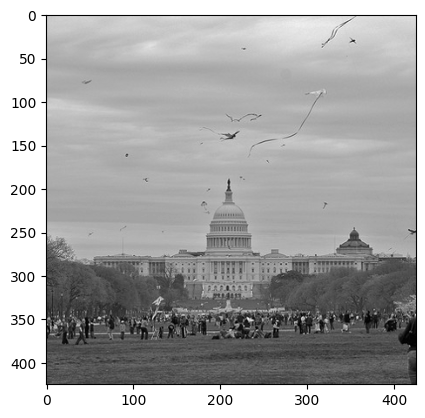

In [ ]:
sub_index = math.floor(prediction_model1D_index / global_val_count)
# print(sub_index)
showSingleImage(SUBJ_LIST[sub_index], global_idx_val[prediction_model1D_index])

In [ ]:
label_count = 8
# print(prediction_model[prediction_model1D_index])
top_3_indices = np.argsort(prediction_model[prediction_model1D_index])[-label_count:][::-1]
top_3_values = prediction_model[prediction_model1D_index][top_3_indices]
print(f"Top 3 prediction indices: {top_3_indices} | Top 3 prediction values: {top_3_values}")
print("Top 3 prediction labels:", global_labels_name[top_3_indices])

Top 3 prediction indices: [  0 119 116 123 129   2 100 105] | Top 3 prediction values: [0.5738247  0.5141351  0.42198777 0.4147803  0.3686081  0.27827993
 0.27377722 0.23568879]
Top 3 prediction labels: Index(['person', 'sky-other-merged', 'tree-merged', 'pavement-merged',
       'building-other-merged', 'car', 'road', 'snow'],
      dtype='object')


In [ ]:
### Load subject test data

In [ ]:
# global_fmri_l_test = None
# global_fmri_r_test = None

# load_mode= 'test'
# subject_count = 3

# fit_fmri_dimension = True
# fit_fmri_target_size = 21025 # 145 x 145

# for sub in SUBJ_LIST[:subject_count]:

#   print(sub)

#   sub_obj = ReadObject(sub)
#   _, _, masks, fmri, _ = sub_obj.load(mode=load_mode, load_images=False)

#   ((_, _), (fmri_l_test, _), (fmri_r_test, _), (_, _), (_, _)) = (
#     sub_obj.split_data(_, fmri, None, split_ratio=1, count=None, permutate=False))

#   if fit_fmri_dimension:
#     additional_rows = np.zeros(shape=(fmri_l_test.shape[0], fit_fmri_target_size - fmri_l_test.shape[1]))
#     fmri_l_test = np.concatenate((fmri_l_test, additional_rows), axis=1)
#   fmri_l_test = min_max_normalize(fmri_l_test) # fmri_l_train / np.max(fmri_l_train)
#   print(f"fmri_l_test  shape: {fmri_l_test.shape} | min: {np.min(fmri_l_test)} max: {np.max(fmri_l_test)}")
#   global_fmri_l_test = fmri_l_test if global_fmri_l_train is None else np.vstack((global_fmri_l_train, fmri_l_test))

#   if fit_fmri_dimension:
#     additional_rows = np.zeros(shape=(fmri_r_test.shape[0], fit_fmri_target_size - fmri_r_test.shape[1]))
#     fmri_r_test = np.concatenate((fmri_r_test, additional_rows), axis=1)
#   fmri_r_test = min_max_normalize(fmri_r_test) # fmri_r_train / np.max(fmri_r_train)
#   print(f"fmri_r_test  shape: {fmri_r_test.shape} | min: {np.min(fmri_r_test)} max: {np.max(fmri_r_test)}")
#   global_fmri_r_test = fmri_r_test if global_fmri_r_train is None else np.vstack((global_fmri_r_train, fmri_r_test))

#   # Free memory
#   fmri_l_train, fmri_r_train = None, None
#   masks, fmri = None, None
#   additional_rows = None

#   print('')

In [ ]:
# print('Global test shapes:')
# print(global_fmri_l_test.shape)
# print(global_fmri_r_test.shape)